## Import Libraries

In [13]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Merged Data

Load the merged cohort dataframes. We'll recreate them here for convenience.

In [14]:
# Define cohorts
cohorts = {
    'BRCA': 'Breast Cancer',
    'LUAD': 'Lung Adenocarcinoma',
    'LUSC': 'Lung Squamous Cell Carcinoma',
    'SKCM': 'Melanoma',
    'MESO': 'Mesothelioma',
    'COAD': 'Colon Cancer',
    'LAML': 'Acute Myeloid Leukemia'
}

# Data directory
data_dir = Path('/workspace/data/GDCdata')

print(f"Data directory: {data_dir}")
print(f"Number of cohorts: {len(cohorts)}")

Data directory: /workspace/data/GDCdata
Number of cohorts: 7


In [15]:
# Helper functions to load and merge data
def load_and_merge_cohort(cohort_name, data_dir):
    """Load and merge RNA-Seq and clinical data for a cohort."""
    # Load RNA-Seq data
    rnaseq_path = data_dir / f"TCGA-{cohort_name}.star_fpkm-uq.tsv"
    clinical_path = data_dir / f"TCGA-{cohort_name}.clinical.tsv"

    if not rnaseq_path.exists() or not clinical_path.exists():
        print(f"Warning: Data files for {cohort_name} not found!")
        return None

    print(f"Loading {cohort_name}...", end=" ")

    # Load and transpose RNA-Seq data
    rnaseq_df = pd.read_csv(rnaseq_path, sep='\t', index_col=0).T
    rnaseq_df.reset_index(inplace=True)
    rnaseq_df.rename(columns={'index': 'sample'}, inplace=True)

    # Load clinical data
    clinical_df = pd.read_csv(clinical_path, sep='\t')

    # Merge
    merged_df = pd.merge(clinical_df, rnaseq_df, on='sample', how='inner')

    print(f"✓ {merged_df.shape[0]} samples")
    return merged_df


# Load all cohorts
print("Loading cohort data...\n")
merged_cohorts = {}
for cohort_name in cohorts.keys():
    merged_df = load_and_merge_cohort(cohort_name, data_dir)
    if merged_df is not None:
        merged_cohorts[cohort_name] = merged_df

print(f"\nSuccessfully loaded {len(merged_cohorts)} cohorts")

Loading cohort data...

Loading BRCA... 

✓ 1226 samples
Loading LUAD... ✓ 589 samples
Loading LUSC... ✓ 552 samples
Loading SKCM... ✓ 473 samples
Loading MESO... ✓ 87 samples
Loading COAD... ✓ 514 samples
Loading LAML... ✓ 151 samples

Successfully loaded 7 cohorts


## Explore Available Clinical Features

In [16]:
# Identify key clinical features that exist across cohorts
clinical_features_of_interest = [
    'sample',
    'gender.demographic',
    'race.demographic',
    'ethnicity.demographic',
    'vital_status.demographic',
    'age_at_index.demographic',
    'age_at_diagnosis.diagnoses',
    'primary_diagnosis.diagnoses',
    'ajcc_pathologic_stage.diagnoses',
    'tumor_grade.diagnoses',
    'primary_site',
    'disease_type'
]

# Check which features are available in each cohort
print("Clinical feature availability across cohorts:\n")
for cohort_name, df in merged_cohorts.items():
    available = [
        feat for feat in clinical_features_of_interest if feat in df.columns]
    print(f"{cohort_name}: {len(available)}/{len(clinical_features_of_interest)} features")

# Get common features across all cohorts
common_features = set(clinical_features_of_interest)
for df in merged_cohorts.values():
    common_features = common_features.intersection(df.columns)

print(f"\nCommon clinical features across all cohorts: {len(common_features)}")
print(list(common_features)[:10])

Clinical feature availability across cohorts:

BRCA: 12/12 features
LUAD: 12/12 features
LUSC: 12/12 features
SKCM: 12/12 features
MESO: 12/12 features
COAD: 12/12 features
LAML: 11/12 features

Common clinical features across all cohorts: 11
['tumor_grade.diagnoses', 'age_at_diagnosis.diagnoses', 'primary_site', 'vital_status.demographic', 'primary_diagnosis.diagnoses', 'age_at_index.demographic', 'disease_type', 'gender.demographic', 'ethnicity.demographic', 'race.demographic']


## Sample Size Distribution Across Cohorts

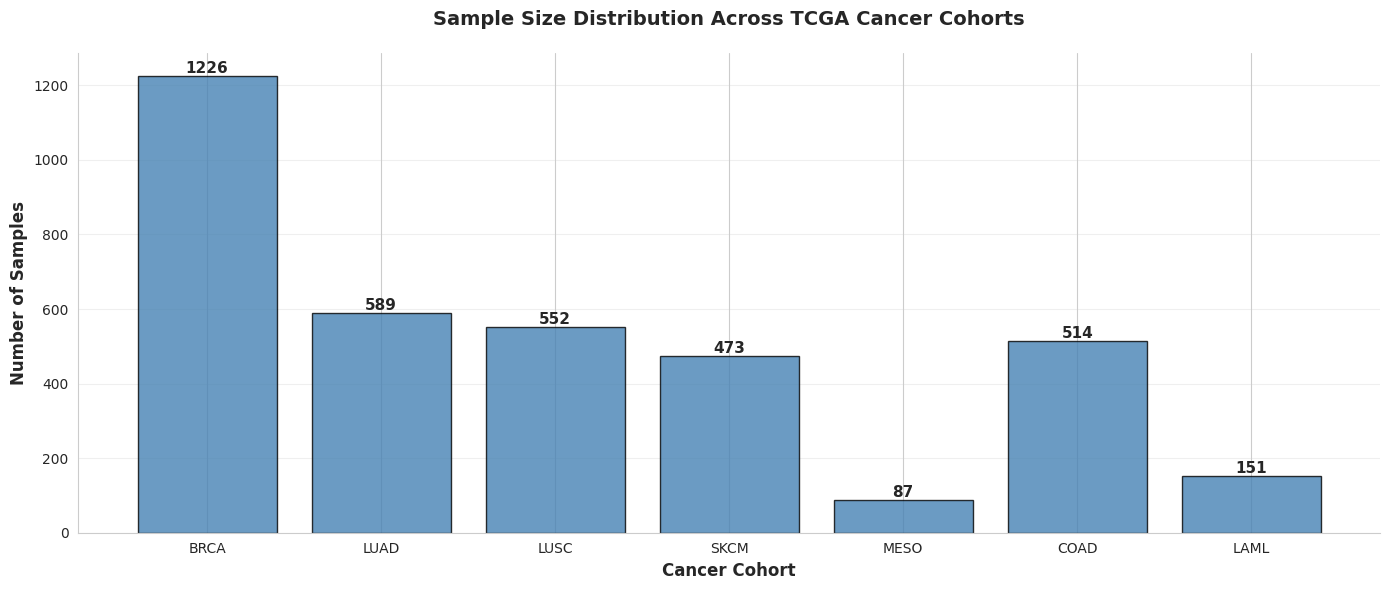


Total samples across all cohorts: 3592


In [17]:
# Visualize sample sizes across cohorts
cohort_names = []
sample_counts = []

for cohort_name, df in merged_cohorts.items():
    cohort_names.append(f"{cohort_name}")
    sample_counts.append(df.shape[0])

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(len(cohort_names)), sample_counts,
              color='steelblue', alpha=0.8, edgecolor='black')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, sample_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Cancer Cohort', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Sample Size Distribution Across TCGA Cancer Cohorts',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(cohort_names)))
ax.set_xticklabels(cohort_names, rotation=0, ha='center', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\nTotal samples across all cohorts: {sum(sample_counts)}")

## Gender Distribution

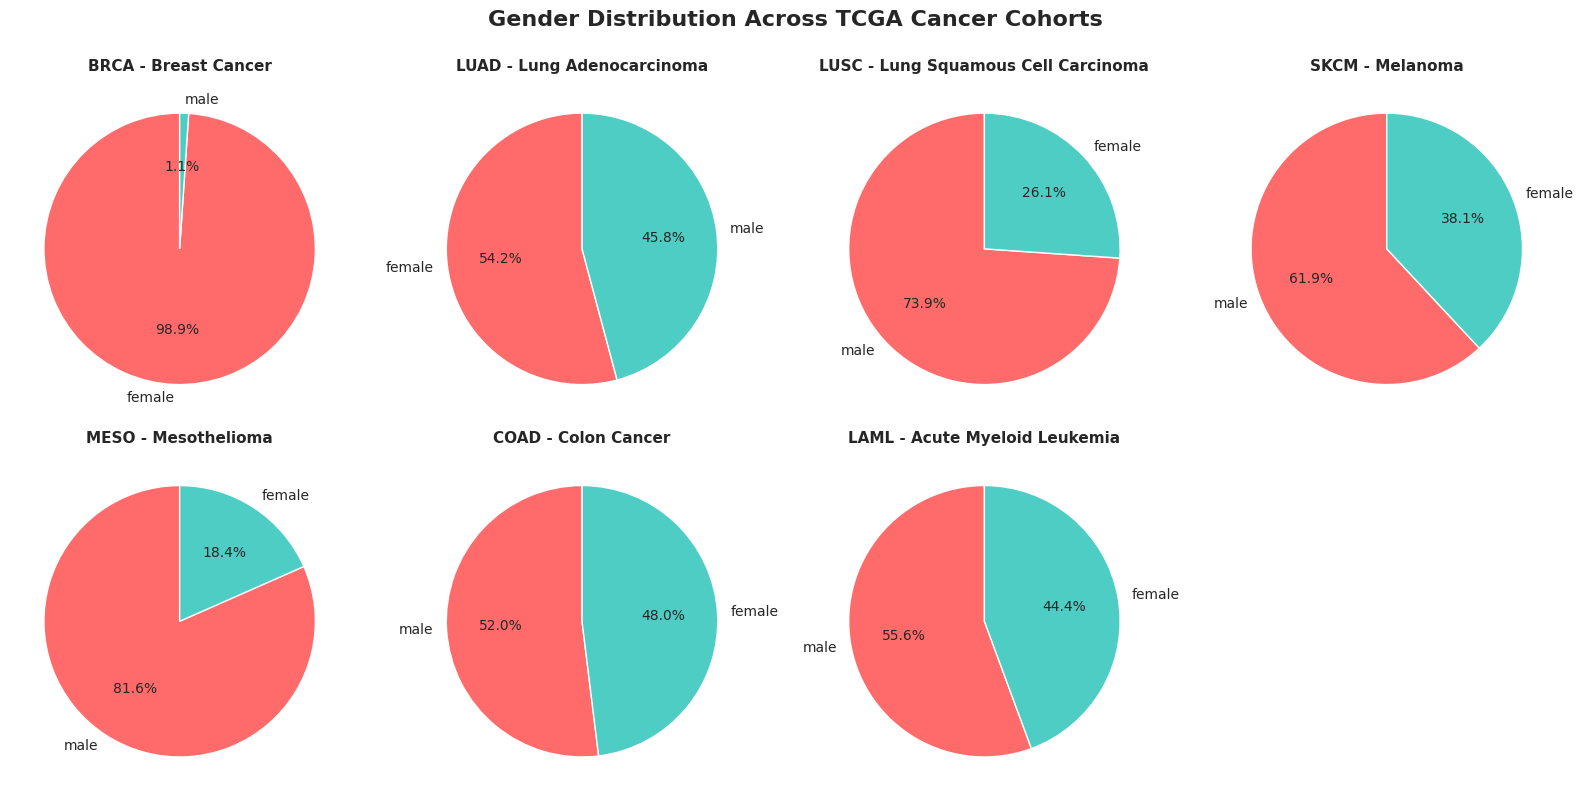

In [18]:
# Gender distribution across cohorts
gender_col = 'gender.demographic'

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (cohort_name, df) in enumerate(merged_cohorts.items()):
    if gender_col in df.columns:
        gender_counts = df[gender_col].value_counts()

        # Create pie chart
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181']
        axes[idx].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                      colors=colors[:len(gender_counts)], startangle=90)
        axes[idx].set_title(
            f'{cohort_name} - {cohorts[cohort_name]}', fontweight='bold', fontsize=11)
    else:
        axes[idx].text(0.5, 0.5, 'Gender data\nnot available',
                       ha='center', va='center', fontsize=12)
        axes[idx].set_title(f'{cohort_name}', fontweight='bold')
        axes[idx].axis('off')

# Hide the last empty subplot if we have less than 8 cohorts
if len(merged_cohorts) < 8:
    axes[-1].axis('off')

plt.suptitle('Gender Distribution Across TCGA Cancer Cohorts',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Vital Status Distribution

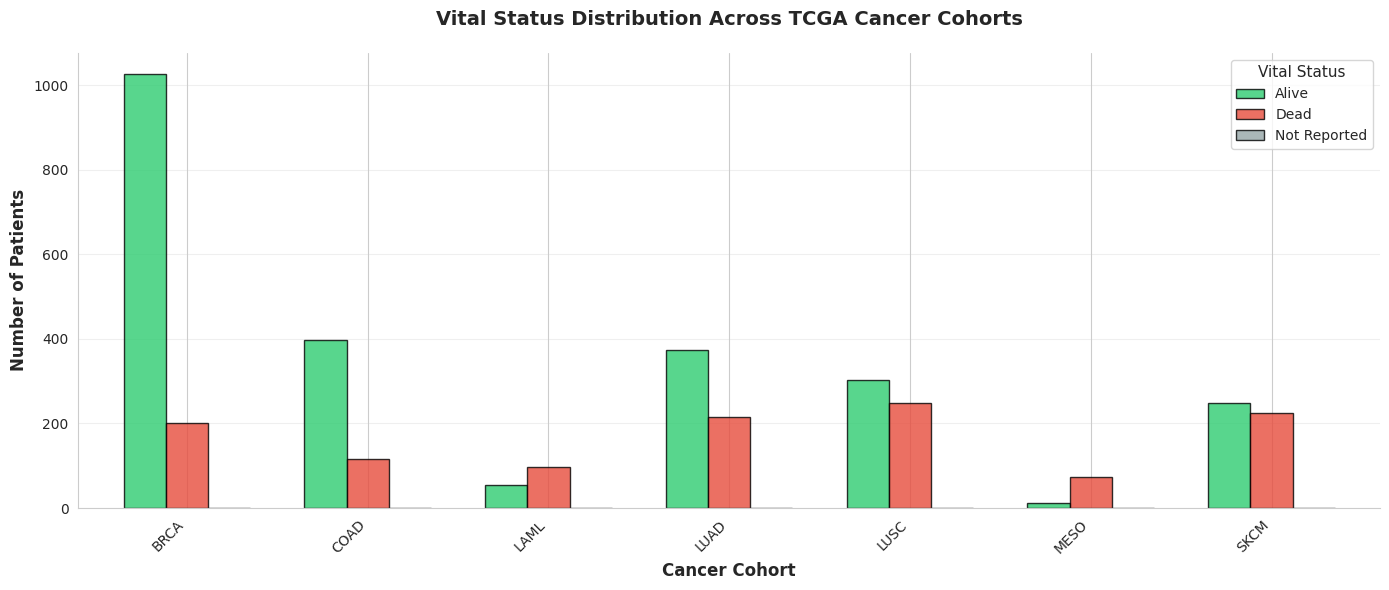

In [19]:
# Vital status distribution
vital_status_col = 'vital_status.demographic'

# Prepare data for grouped bar chart
vital_status_data = []
for cohort_name, df in merged_cohorts.items():
    if vital_status_col in df.columns:
        status_counts = df[vital_status_col].value_counts()
        for status, count in status_counts.items():
            vital_status_data.append({
                'Cohort': cohort_name,
                'Vital Status': status,
                'Count': count
            })

vital_status_df = pd.DataFrame(vital_status_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))

if not vital_status_df.empty:
    # Pivot for grouped bar chart
    pivot_df = vital_status_df.pivot(
        index='Cohort', columns='Vital Status', values='Count').fillna(0)

    pivot_df.plot(kind='bar', ax=ax, color=['#2ECC71', '#E74C3C', '#95A5A6'],
                  alpha=0.8, edgecolor='black', width=0.7)

    ax.set_xlabel('Cancer Cohort', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
    ax.set_title('Vital Status Distribution Across TCGA Cancer Cohorts',
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Vital Status', fontsize=10, title_fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Age at Diagnosis Distribution


Age at Diagnosis Summary Statistics (years):
        Mean  Std Dev  Median   Min   Max
Cohort                                   
BRCA    58.9     13.3    58.9  26.6  90.0
COAD    67.8     13.1    69.4  31.2  90.0
LAML    54.6     16.1    56.1  21.6  88.5
LUAD    65.6     10.2    66.4  33.3  88.8
LUSC    67.8      8.6    68.6  39.3  90.0
MESO    63.5      9.8    64.6  28.8  81.9
SKCM    58.7     15.7    58.5  15.6  90.0


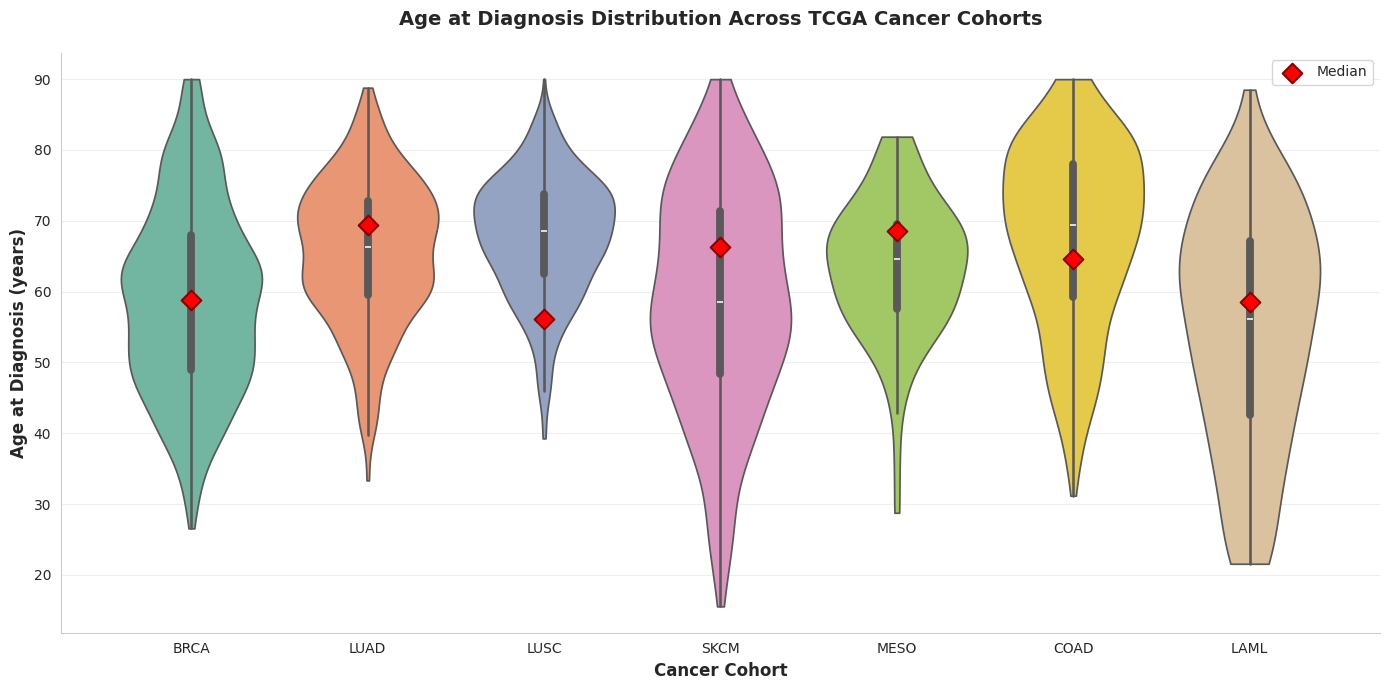

In [20]:
# Age at diagnosis distribution
age_col = 'age_at_diagnosis.diagnoses'

# Prepare data for violin plot
age_data = []
for cohort_name, df in merged_cohorts.items():
    if age_col in df.columns:
        # Convert to years and filter out missing values
        ages = pd.to_numeric(df[age_col], errors='coerce') / 365.25
        ages = ages.dropna()
        for age in ages:
            age_data.append({
                'Cohort': cohort_name,
                'Age (years)': age
            })

age_df = pd.DataFrame(age_data)

# Create violin plot
fig, ax = plt.subplots(figsize=(14, 7))

if not age_df.empty:
    sns.violinplot(data=age_df, x='Cohort', y='Age (years)', ax=ax,
                   palette='Set2', inner='box', cut=0)

    # Add median points
    medians = age_df.groupby('Cohort')['Age (years)'].median()
    positions = range(len(medians))
    ax.scatter(positions, medians.values, color='red', s=100, zorder=3,
               label='Median', marker='D', edgecolors='darkred', linewidths=1.5)

    ax.set_xlabel('Cancer Cohort', fontsize=12, fontweight='bold')
    ax.set_ylabel('Age at Diagnosis (years)', fontsize=12, fontweight='bold')
    ax.set_title('Age at Diagnosis Distribution Across TCGA Cancer Cohorts',
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Print summary statistics
    print("\nAge at Diagnosis Summary Statistics (years):")
    print("="*60)
    summary = age_df.groupby('Cohort')['Age (years)'].describe()[
        ['mean', 'std', '50%', 'min', 'max']]
    summary.columns = ['Mean', 'Std Dev', 'Median', 'Min', 'Max']
    print(summary.round(1))

plt.tight_layout()
plt.show()

## Tumor Stage Distribution

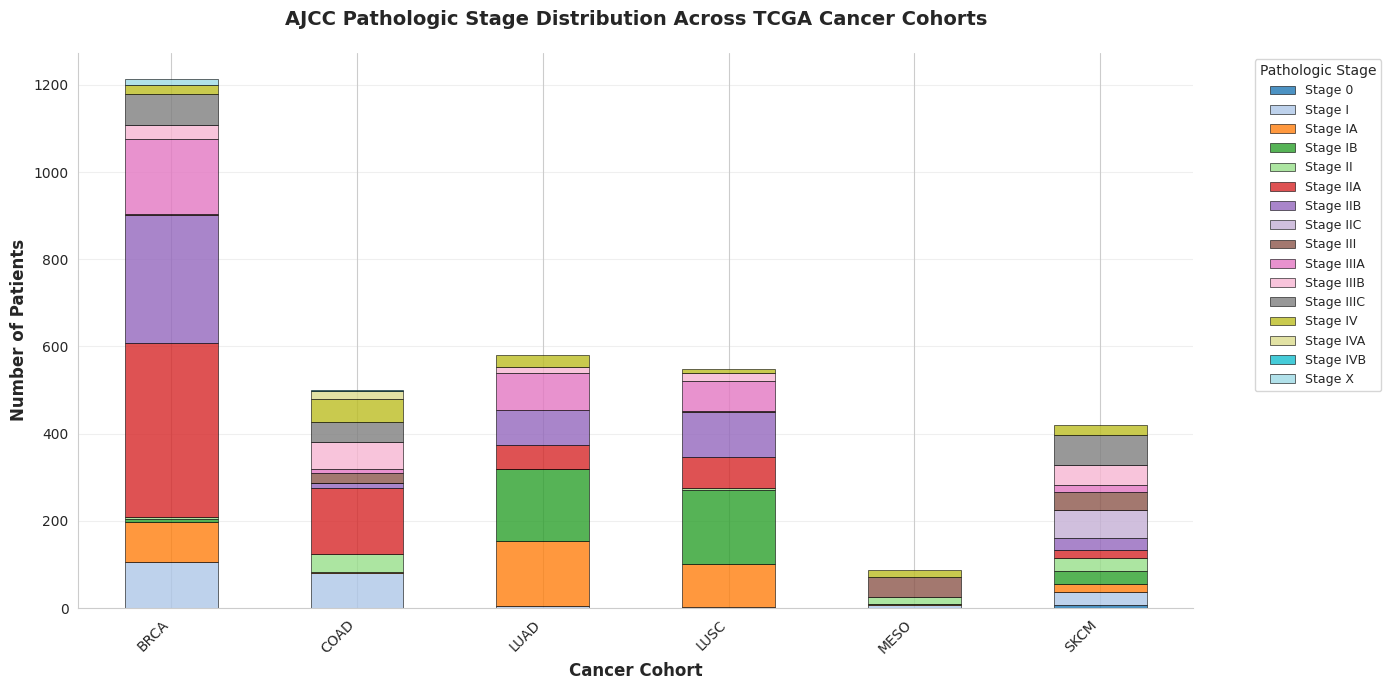

In [21]:
# Tumor stage distribution
stage_col = 'ajcc_pathologic_stage.diagnoses'

# Prepare data
stage_data = []
for cohort_name, df in merged_cohorts.items():
    if stage_col in df.columns:
        stage_counts = df[stage_col].value_counts()
        for stage, count in stage_counts.items():
            if pd.notna(stage) and stage != 'Not Reported':
                stage_data.append({
                    'Cohort': cohort_name,
                    'Stage': stage,
                    'Count': count
                })

stage_df = pd.DataFrame(stage_data)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

if not stage_df.empty:
    # Pivot for stacked bar chart
    pivot_df = stage_df.pivot(
        index='Cohort', columns='Stage', values='Count').fillna(0)

    # Sort columns to get logical stage order
    stage_order = sorted(pivot_df.columns, key=lambda x: (
        'Stage' not in str(x),  # Put stages first
        str(x)
    ))
    pivot_df = pivot_df[stage_order]

    pivot_df.plot(kind='bar', stacked=True, ax=ax,
                  colormap='tab20', alpha=0.8, edgecolor='black', linewidth=0.5)

    ax.set_xlabel('Cancer Cohort', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
    ax.set_title('AJCC Pathologic Stage Distribution Across TCGA Cancer Cohorts',
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Pathologic Stage', bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Race/Ethnicity Distribution

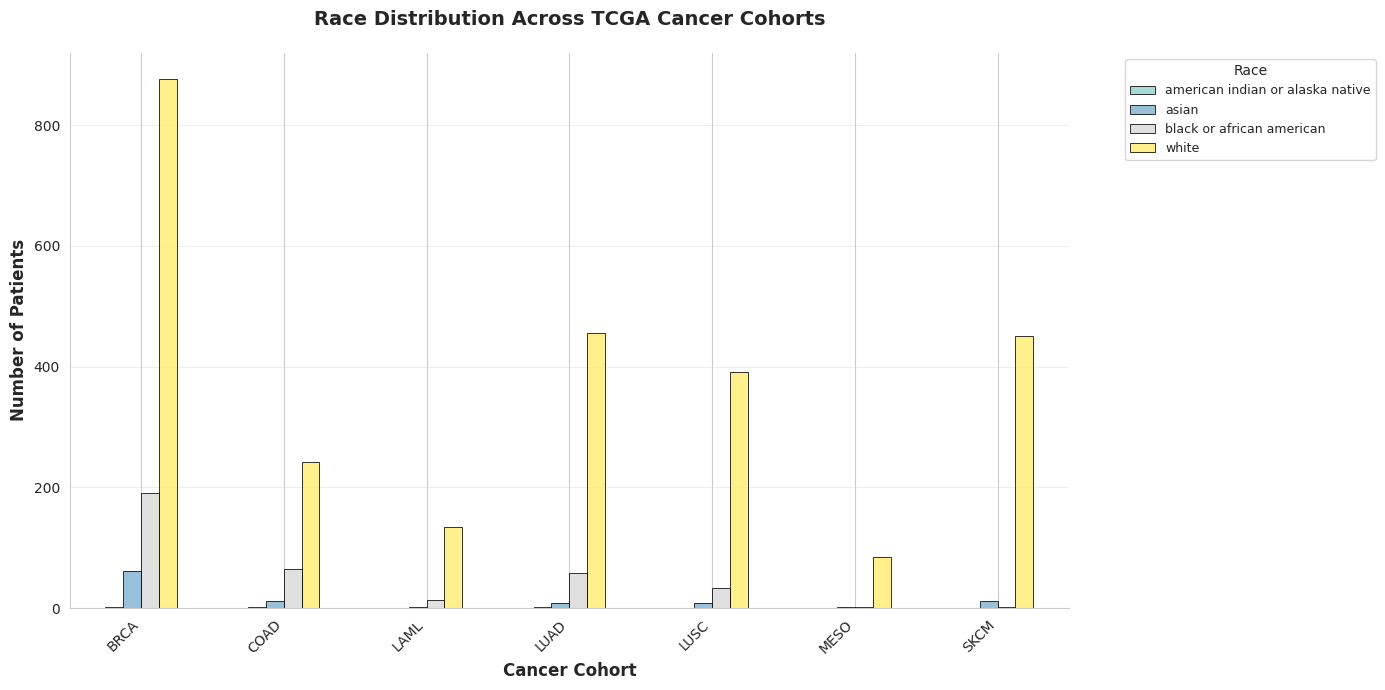


Race Distribution Summary:
Race
white                               2635
black or african american            362
asian                                105
american indian or alaska native       4
Name: Count, dtype: int64


In [22]:
# Race distribution across cohorts
race_col = 'race.demographic'

# Prepare data
race_data = []
for cohort_name, df in merged_cohorts.items():
    if race_col in df.columns:
        race_counts = df[race_col].value_counts()
        for race, count in race_counts.items():
            if pd.notna(race) and race.lower() not in ['not reported', 'not available']:
                race_data.append({
                    'Cohort': cohort_name,
                    'Race': race,
                    'Count': count,
                    'Percentage': count / len(df) * 100
                })

race_df = pd.DataFrame(race_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

if not race_df.empty:
    # Pivot for grouped bar chart
    pivot_df = race_df.pivot(
        index='Cohort', columns='Race', values='Count').fillna(0)

    pivot_df.plot(kind='bar', ax=ax, colormap='Set3',
                  alpha=0.8, edgecolor='black', linewidth=0.7)

    ax.set_xlabel('Cancer Cohort', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
    ax.set_title('Race Distribution Across TCGA Cancer Cohorts',
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary
print("\nRace Distribution Summary:")
print("="*60)
race_summary = race_df.groupby(
    'Race')['Count'].sum().sort_values(ascending=False)
print(race_summary)

## Cancer Subtype Distribution

**Note:** Cancer subtype information varies by cohort and may be found in different clinical fields. For LAML (Leukemia), phenotype expression might refer to different molecular or cytogenetic markers rather than traditional subtypes.

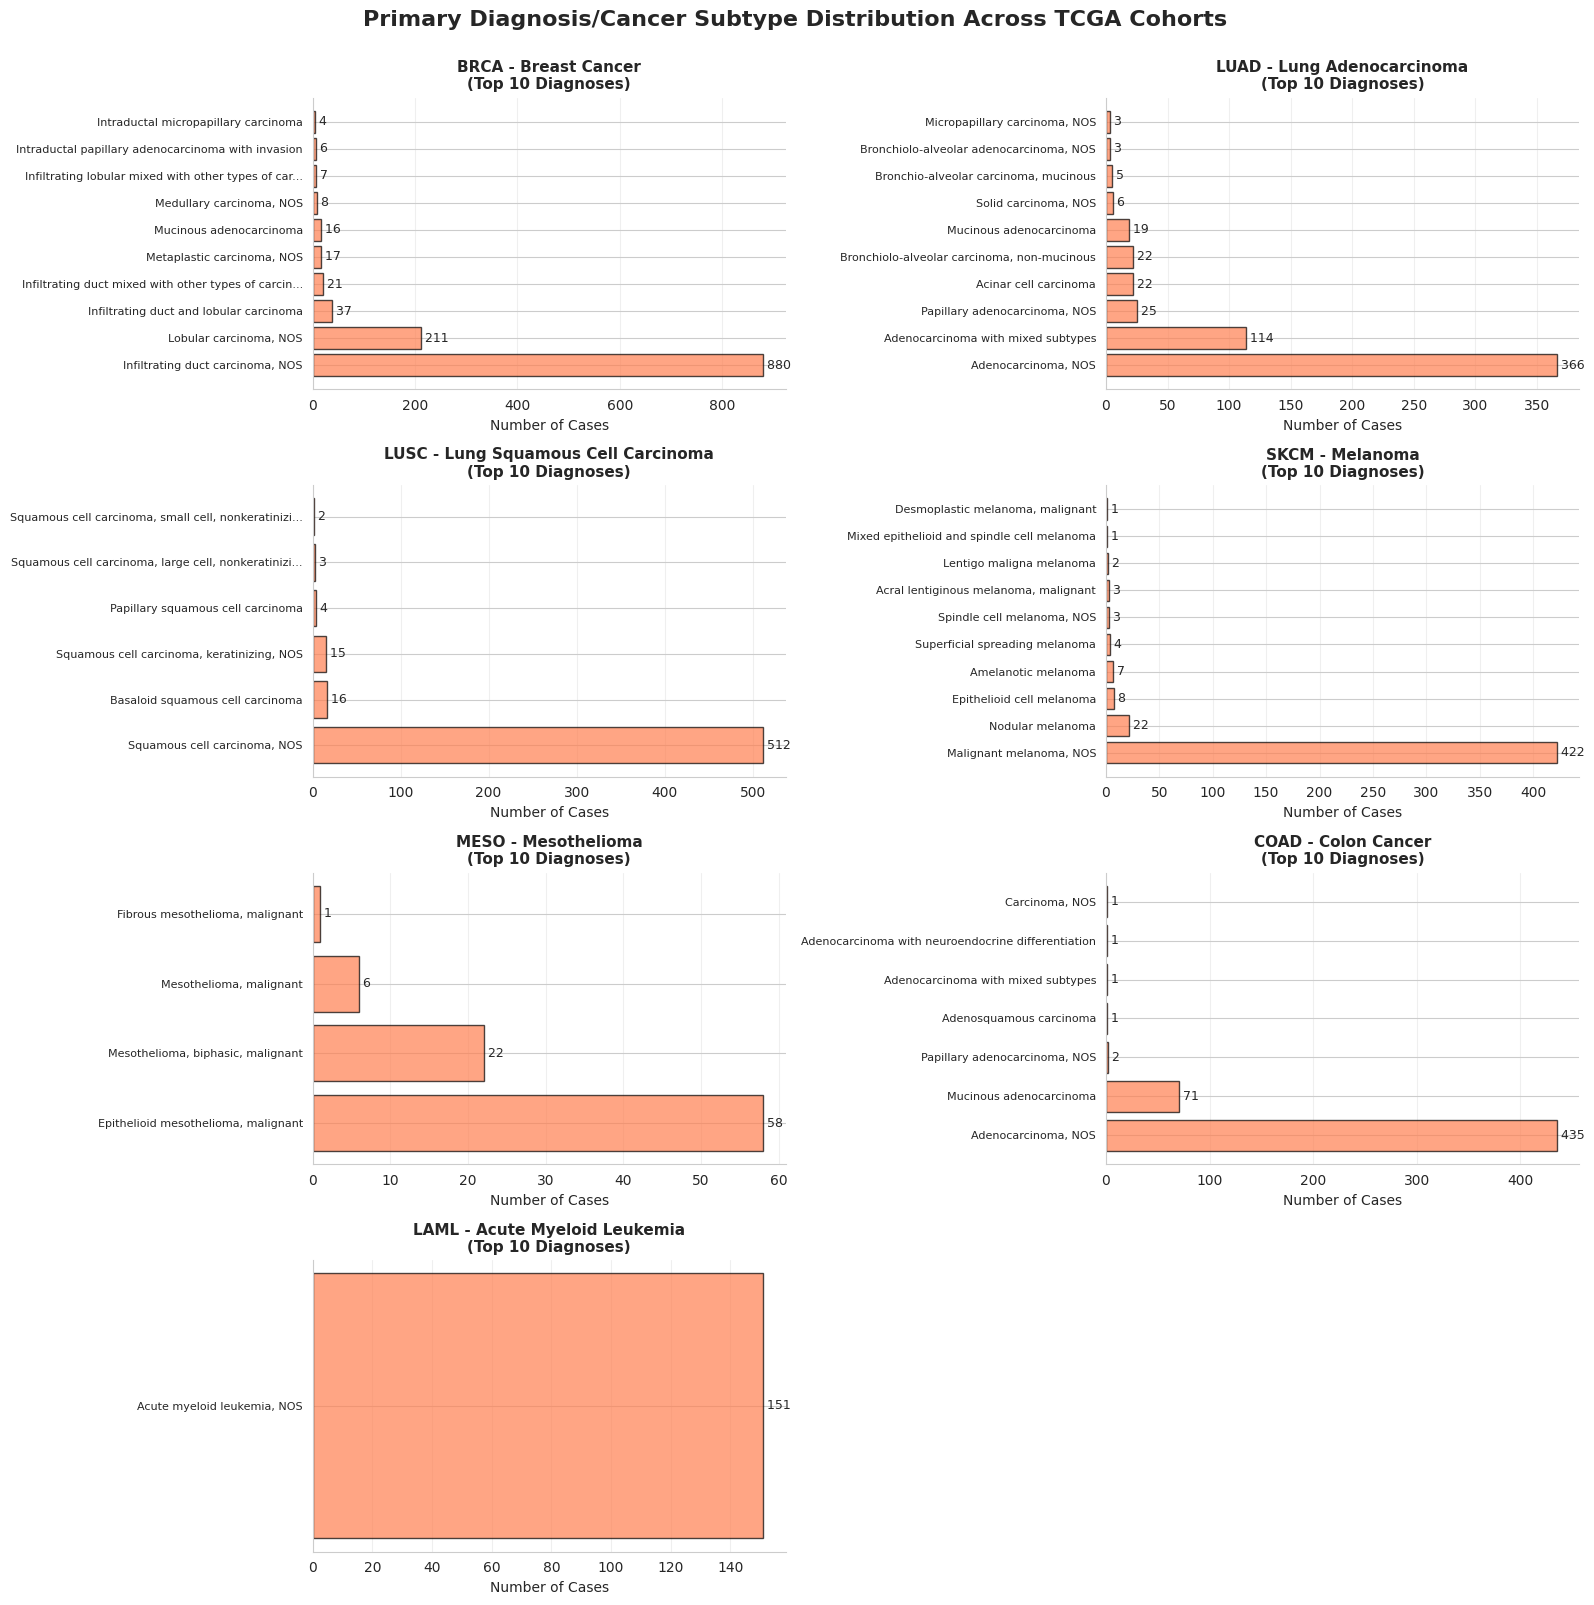


Detailed Cancer Subtype/Diagnosis Information:

BRCA (Breast Cancer):
--------------------------------------------------------------------------------
Total unique diagnoses: 22
Most common: Infiltrating duct carcinoma, NOS (880 cases)
Top 5 diagnoses:
  1. Infiltrating duct carcinoma, NOS: 880 (71.8%)
  2. Lobular carcinoma, NOS: 211 (17.2%)
  3. Infiltrating duct and lobular carcinoma: 37 (3.0%)
  4. Infiltrating duct mixed with other types of carcinoma: 21 (1.7%)
  5. Metaplastic carcinoma, NOS: 17 (1.4%)

LUAD (Lung Adenocarcinoma):
--------------------------------------------------------------------------------
Total unique diagnoses: 12
Most common: Adenocarcinoma, NOS (366 cases)
Top 5 diagnoses:
  1. Adenocarcinoma, NOS: 366 (62.1%)
  2. Adenocarcinoma with mixed subtypes: 114 (19.4%)
  3. Papillary adenocarcinoma, NOS: 25 (4.2%)
  4. Acinar cell carcinoma: 22 (3.7%)
  5. Bronchiolo-alveolar carcinoma, non-mucinous: 22 (3.7%)

LUSC (Lung Squamous Cell Carcinoma):
-------------

In [23]:
# Cancer subtype/primary diagnosis distribution
# For most cancers, primary_diagnosis gives us subtype information
diagnosis_col = 'primary_diagnosis.diagnoses'

# Create subplots for each cohort
n_cohorts = len(merged_cohorts)
n_cols = 2
n_rows = (n_cohorts + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() if n_cohorts > 1 else [axes]

for idx, (cohort_name, df) in enumerate(merged_cohorts.items()):
    ax = axes[idx]

    if diagnosis_col in df.columns:
        diagnosis_counts = df[diagnosis_col].value_counts().head(
            10)  # Top 10 subtypes

        if not diagnosis_counts.empty:
            # Create horizontal bar chart for better label readability
            y_pos = range(len(diagnosis_counts))
            bars = ax.barh(y_pos, diagnosis_counts.values,
                           color='coral', alpha=0.7, edgecolor='black')

            # Add value labels
            for i, (bar, count) in enumerate(zip(bars, diagnosis_counts.values)):
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2., f' {count}',
                        ha='left', va='center', fontsize=9)

            # Shorten labels if too long
            labels = [label[:50] + '...' if len(label) > 50 else label
                      for label in diagnosis_counts.index]

            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels, fontsize=8)
            ax.set_xlabel('Number of Cases', fontsize=10)
            ax.set_title(f'{cohort_name} - {cohorts[cohort_name]}\n(Top 10 Diagnoses)',
                         fontweight='bold', fontsize=11)
            ax.grid(axis='x', alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else:
            ax.text(0.5, 0.5, 'No diagnosis data', ha='center', va='center')
            ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'Diagnosis column\nnot available',
                ha='center', va='center')
        ax.axis('off')

# Hide unused subplots
for idx in range(n_cohorts, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Primary Diagnosis/Cancer Subtype Distribution Across TCGA Cohorts',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print detailed subtype information for each cohort
print("\nDetailed Cancer Subtype/Diagnosis Information:")
print("="*80)
for cohort_name, df in merged_cohorts.items():
    if diagnosis_col in df.columns:
        print(f"\n{cohort_name} ({cohorts[cohort_name]}):")
        print("-" * 80)
        diagnosis_counts = df[diagnosis_col].value_counts()
        print(f"Total unique diagnoses: {len(diagnosis_counts)}")
        print(
            f"Most common: {diagnosis_counts.index[0]} ({diagnosis_counts.iloc[0]} cases)")
        print(f"Top 5 diagnoses:")
        for i, (diag, count) in enumerate(diagnosis_counts.head(5).items(), 1):
            pct = count / len(df) * 100
            print(f"  {i}. {diag}: {count} ({pct:.1f}%)")

## Primary Site Distribution

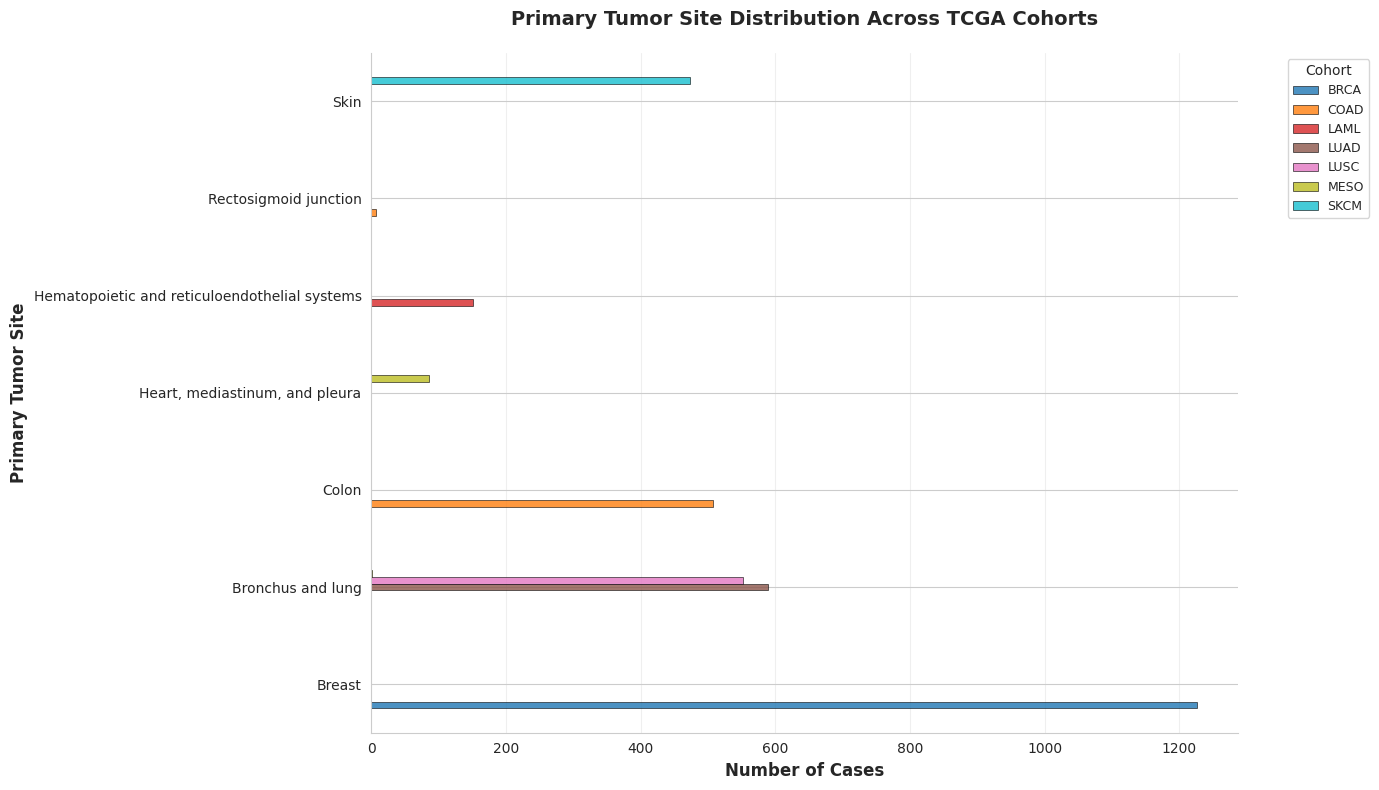

In [24]:
# Primary site distribution (anatomical location of tumor origin)
site_col = 'primary_site'

# Prepare data
site_data = []
for cohort_name, df in merged_cohorts.items():
    if site_col in df.columns:
        site_counts = df[site_col].value_counts()
        for site, count in site_counts.items():
            if pd.notna(site):
                site_data.append({
                    'Cohort': cohort_name,
                    'Primary Site': site,
                    'Count': count
                })

site_df = pd.DataFrame(site_data)

# Create horizontal bar chart showing top sites per cohort
fig, ax = plt.subplots(figsize=(14, 8))

if not site_df.empty:
    # Get top sites across all cohorts
    top_sites = site_df.groupby('Primary Site')[
        'Count'].sum().sort_values(ascending=True).tail(15)

    # Filter data to include only top sites
    filtered_df = site_df[site_df['Primary Site'].isin(top_sites.index)]
    pivot_df = filtered_df.pivot(
        index='Primary Site', columns='Cohort', values='Count').fillna(0)

    pivot_df.plot(kind='barh', ax=ax, stacked=False, colormap='tab10',
                  alpha=0.8, edgecolor='black', linewidth=0.5)

    ax.set_xlabel('Number of Cases', fontsize=12, fontweight='bold')
    ax.set_ylabel('Primary Tumor Site', fontsize=12, fontweight='bold')
    ax.set_title('Primary Tumor Site Distribution Across TCGA Cohorts',
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()